In [1]:
import numpy as np
import pandas as pd

# Scikit-learn Kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import chi2, SelectKBest

# NLTK Kütüphaneleri
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer

# SpaCy Kütüphanesi
!pip install spacy
import spacy


In [2]:
!pip install contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.2 MB/s eta 0:00:00


In [3]:
import os

# /kaggle/input altında hangi dosyalar var, listeleyelim
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


dataset oluşturma

In [4]:
# Read the dataset with name "Emotion_classify_Data.csv" and store it in a variable df
columns = ['id','uygulama','duygu_durumu','metin']
df_train= pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", names=columns)
df_validation = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", names=columns)

In [5]:
df_train.head(5)



,id,uygulama,duygu_durumu,metin
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df_validation.head(5)

,id,uygulama,duygu_durumu,metin
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            74682 non-null  int64 
 1   uygulama      74682 non-null  object
 2   duygu_durumu  74682 non-null  object
 3   metin         73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [8]:
# Check the distribution of Emotion
df_train['duygu_durumu'].value_counts()

duygu_durumu
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [9]:
#örnek gözlemler
for i in range(100):
    if i%25==0:
        print(f"{i+1}: {df_train['metin'][i]} -> {df_train['duygu_durumu'][i]}")

1: im getting on borderlands and i will murder you all , -> Positive
26: The biggest disappointment of my life came a year ago. -> Negative
51: Guilty of sobriety! A bit of a borderline. I was called to work early tomorrow, so I can't catch up. -> Neutral
76: imma probably play live borderlands tps in a bit. that'll be fun -> Positive


In [ ]:
import matplotlib.pyplot as plt

# Uygulama sayımlarını al
uygulama_sayim = df_train['uygulama'].value_counts()

# Grafik çizimi
plt.figure(figsize=(15, 6))
uygulama_sayim.plot(kind='bar', color='skyblue')
plt.title('Uygulama Dağılımı')
plt.xlabel('Uygulama')
plt.ylabel('Frekans')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#id nasıl bir değişken diye kontrol ettiğimizde daha çok bireye veya grupa ait olduğunu gözlemledik
df_train['id'].nunique()




12447

****PREPROCESSİNG İŞLEMLERİ****

In [12]:
# NLTK stopwords ve tokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


replace  urls and users :URL'ler ve kullanıcı adlarını tespit edip değiştirme 

In [13]:
import re
import pandas as pd

def replace_urls_and_users(text):
    if isinstance(text, str): 
        text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
        text = re.sub(r'@\w+', 'AT_USER', text)
        return text
    return text 

df_train['metin'] = df_train['metin'].astype(str).apply(replace_urls_and_users)
df_validation['metin'] = df_validation['metin'].astype(str).apply(replace_urls_and_users)

print(df_train['metin'].head(3))


0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
Name: metin, dtype: object


Kısaltmaların Açılması (Contraction Replacement):“don’t” → “do not”, “can’t” → “can not” gibi.

Bu adım çalışmalarda uygulanmış ve olumsuzlukların doğru algılanmasına etki etmiştir.

In [14]:


import contractions

# Metindeki  kısaltmaları açan fonksiyon
def expand_with_library(text):
    return contractions.fix(text)


    
df_train['metin'] = df_train['metin'].astype(str).apply(expand_with_library)
df_validation['metin'] = df_validation['metin'].astype(str).apply(expand_with_library)

print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    I am coming to the borders and I will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Küçük Harfe Dönüştürme (Lowercasing):“Good” ve “good” gibi aynı kelimenin farklı halleri tekilleştirilir.

In [15]:
# Metni küçük harfe dönüştürme işlemi
df_train['metin'] = df_train['metin'].str.lower()
df_validation['metin'] = df_validation['metin'].str.lower()


print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Sayıların Kaldırılması:genellikle duygu içermez; bu yüzden çıkarılır.

In [16]:
import re

# Sayıları kaldırma işlemi
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'\d+', '', str(s)))


print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Tekrarlanan noktalama işaretlerini tek örnekle değiştirme:"!!!” veya “???” gibi tekrar eden noktalama işaretleri özel etiketlerle değiştirilir.

In [17]:
df_train['metin'] = df_train['metin'].apply(lambda s: re.sub(r'([!?.,])\1+', r'\1', s))
df_validation['metin'] = df_validation['metin'].apply(lambda s: re.sub(r'([!?.,])\1+', r'\1', s))



print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


noktalama işaretlerini kaldırma

In [18]:
df_train['metin'] = df_train['metin'].str.replace('[^\w\s]', '')
df_validation['metin'] = df_validation['metin'].str.replace('[^\w\s]', '')


print(df_train['metin'].head(3))


0    i am getting on borderlands and i will murder ...
1    i am coming to the borders and i will kill you...
2    i am getting on borderlands and i will kill yo...
Name: metin, dtype: object


Stopwords Kaldırma Ancak:“a”, “the”, “is” gibi anlamsız kelimeleri kaldırdık ancak “not”, “no” ve “never” gibi olumsuzluk içeren stopword’ler koruduk.

In [19]:

# 2. Negation kelimeleri (genişletilmiş set)
negations = {
    'not', 'no', 'never', 'none', 'cannot',
    'do not', 'does not', 'did not',
    'has not', 'have not', 'had not',
    'will not', 'would not', 'can not', 'should not',
    'might not', 'must not'
}

# 3. Stopwords listesinden negation'ları çıkar
stop_words = set(stopwords.words('english')) - negations

# 4. Metin üzerinde kelime bazlı stopword temizliği
df_train['metin'] = df_train['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)
df_validation['metin'] = df_validation['metin'].apply(
    lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])
)

Tokenizasyon:Metin, kelime veya sembol bazlı parçalara ayrılır (kelimelere bölme işlemidir).

In [20]:
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# 2. Tokenizasyon (kısaltmalar açıldıktan sonra yapılmalı!)
df_train['tokens'] = df_train['metin'].apply(word_tokenize)
df_validation['tokens'] = df_validation['metin'].apply(word_tokenize)


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Lemmatization:Kelimeler kök hallerine indirdik (örn. “playing”, “played” → “play”).

In [21]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Gerekli dosyaları indir (sadece ilk çalıştırmada gerekli)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

# POS tag'leri WordNet formatına çevirme fonksiyonu
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default olarak isim kabul edilir

lemmatizer = WordNetLemmatizer()

# Hem df_train hem de df_validation için lemmatization uygulama
df_train['tokens'] = df_train['tokens'].apply(lambda toks: [
    lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tag(toks)
])

df_validation['tokens'] = df_validation['tokens'].apply(lambda toks: [
    lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tag(toks)
])



print(df_train['tokens'].head(3))


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


0       [get, borderland, murder, ,]
1       [come, border, kill, all, ,]
2    [get, borderland, kill, all, ,]
Name: tokens, dtype: object


Bag Of words

In [ ]:
""" # HİPERPARAMETRE OPTİMİZASYONU
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import expon, randint
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Pipeline tanımı
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('mlp', MLPClassifier(
        max_iter=500, random_state=42,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
        warm_start=True
    ))
])

# 2) Veri
x = df_train['tokens'].apply(lambda t: ' '.join(t)).values
y = df_train['duygu_durumu'].values

# 3) Kaba arama: RandomizedSearchCV ile hızlı keşif
param_dist = {
    # ngram_range’nin iki uç seçeneği
    'vect__ngram_range': [(1,1), (1,2)],
    # max_df, min_df’yi uniform dağılımdan az sayıda örnekle
    'vect__max_df': expon(loc=0.7, scale=0.3),  
    'vect__min_df': randint(1, 5),
    # katman sayısı ve büyüklüğü sınırlı kombinasyon
    'mlp__hidden_layer_sizes': [(64,), (128,), (64,32)],
    # alpha ve lr; log-ölçekli expon
    'mlp__alpha': expon(scale=1e-3),
    'mlp__learning_rate_init': expon(scale=1e-3),
}

rand_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,           # sadece 20 rastgele deneme
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rand_search.fit(x, y)
print("=== Kaba Arama Sonrası En İyi Parametreler ===")
print(rand_search.best_params_)

# 4) Daraltılmış HalvingGridSearchCV: umut verenlerin etrafında ince ayar
best = rand_search.best_params_
param_grid = {
    'vect__ngram_range': [best['vect__ngram_range']],  # önceki en iyiyi sabitle
    'vect__max_df': [round(best['vect__max_df'],2), min(1.0, best['vect__max_df']+0.1)],
    'vect__min_df': [best['vect__min_df'], max(1, best['vect__min_df']-1)],
    'mlp__hidden_layer_sizes': [best['mlp__hidden_layer_sizes']],
    'mlp__alpha': [best['mlp__alpha']*0.5, best['mlp__alpha'], best['mlp__alpha']*2],
    'mlp__learning_rate_init': [best['mlp__learning_rate_init']*0.5, best['mlp__learning_rate_init'], best['mlp__learning_rate_init']*2],
}

halving = HalvingGridSearchCV(
    pipeline,
    param_grid=param_grid,
    factor=2,            # her turda yarıya indirge
    cv=3,
    verbose=2,
    n_jobs=-1
)
halving.fit(x, y)
print("\n=== İnce Ayar Sonrası En İyi Parametreler ===")
print(halving.best_params_)

# 5) Son modeli al, değerlendirme
best_model = halving.best_estimator_
X_tr, X_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=42)
best_model.fit(X_tr, y_tr)
y_pred = best_model.predict(X_te)

print("\nClassification Report:\n", classification_report(y_te, y_pred))
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.named_steps['mlp'].classes_,
            yticklabels=best_model.named_steps['mlp'].classes_)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()
"""

In [23]:
#print("\n=== İnce Ayar Sonrası En İyi Parametreler ===")
#print(halving.best_params_)


Iteration 1, loss = 0.75871962
Validation score: 0.890377
Iteration 2, loss = 0.19318656
Validation score: 0.913640
Iteration 3, loss = 0.11675191
Validation score: 0.918996
Iteration 4, loss = 0.09522471
Validation score: 0.917490
Iteration 5, loss = 0.08585142
Validation score: 0.913808
Iteration 6, loss = 0.08073612
Validation score: 0.908619
Iteration 7, loss = 0.07717219
Validation score: 0.905774
Iteration 8, loss = 0.07493441
Validation score: 0.902427
Iteration 9, loss = 0.07337300
Validation score: 0.903933
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
Best model saved to best_mlp_pipeline.pkl
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.96      0.88      0.92      2598
    Negative       0.94      0.93      0.93      4509
     Neutral       0.93      0.91      0.92      3664
    Positive       0.87      0.95      0.91      4166

    accuracy                           0.92     

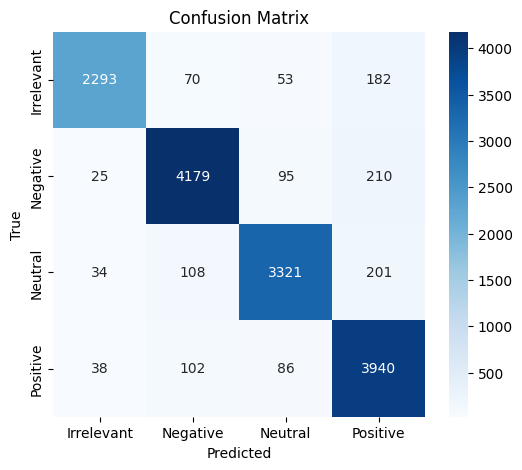

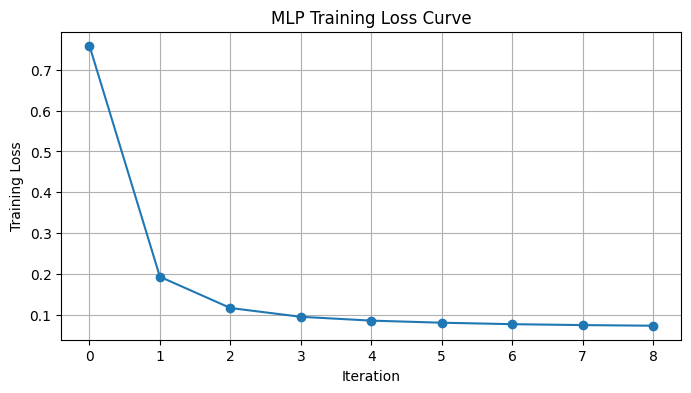

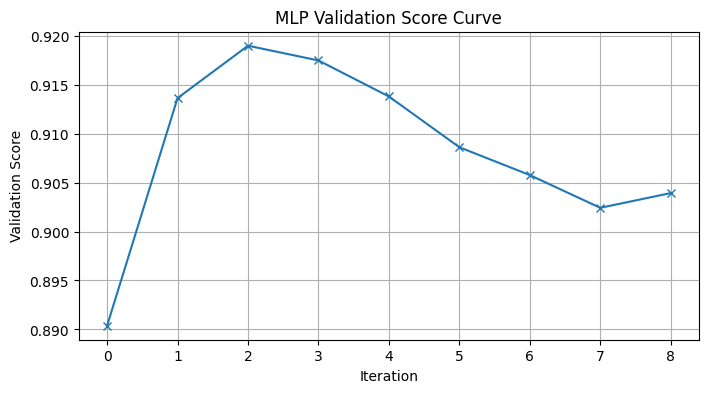

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 1) Özellik / hedef oluşturma
X = df_train['tokens'].apply(lambda t: ' '.join(t))
y = df_train['duygu_durumu']

# 2) Eğitim / test bölmesi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Pipeline: sabitlenmiş en iyi hiperparametrelerle
pipeline = Pipeline([
    ('vect', CountVectorizer(
        ngram_range=(1, 2),
        max_df=0.98,
        min_df=1
    )),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64,),
        alpha=3.895346183291148e-07,
        learning_rate_init=0.0009609782860413563,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=5,
        validation_fraction=0.1,
        verbose=True
    ))
])

# 4) Modeli eğit
pipeline.fit(X_train, y_train)

# 5) En iyi modeli kaydet
best_model_path = "best_mlp_pipeline.pkl"
joblib.dump(pipeline, best_model_path)
print(f"Best model saved to {best_model_path}")

# 6) Tahmin ve değerlendirme
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# 7) Confusion matrix görselleştirme
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=pipeline.named_steps['mlp'].classes_,
    yticklabels=pipeline.named_steps['mlp'].classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 8) Eğitim kayıp eğrisi (loss curve)
mlp = pipeline.named_steps['mlp']
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('MLP Training Loss Curve')
plt.grid(True)
plt.show()

# (Opsiyonel) Validation skor eğrisi
if hasattr(mlp, 'validation_scores_'):
    plt.figure(figsize=(8, 4))
    plt.plot(mlp.validation_scores_, marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Validation Score')
    plt.title('MLP Validation Score Curve')
    plt.grid(True)
    plt.show()

# (Opsiyonel) Daha sonra modeli yükleyip test etmek için:
# loaded_pipeline = joblib.load(best_model_path)
# y_pred_loaded = loaded_pipeline.predict(X_test)
